# **TUGAS PRAKTIKUM 12**

NAMA : Muhammad Hanif Hawari

NIM : 23.11.5572

KELAS : IF01

**BAGIAN 1: Data Sintetis**

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

X, y = make_moons(n_samples=300, noise=0.1, random_state=42)
X = StandardScaler().fit_transform(X)

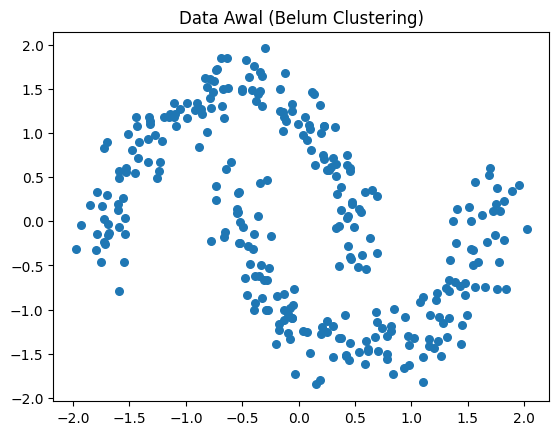

In [47]:
plt.scatter(X[:,0], X[:,1], s=30)
plt.title("Data Awal (Belum Clustering)")
plt.show()

**Clustering DBSCAN**

In [48]:
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(X)

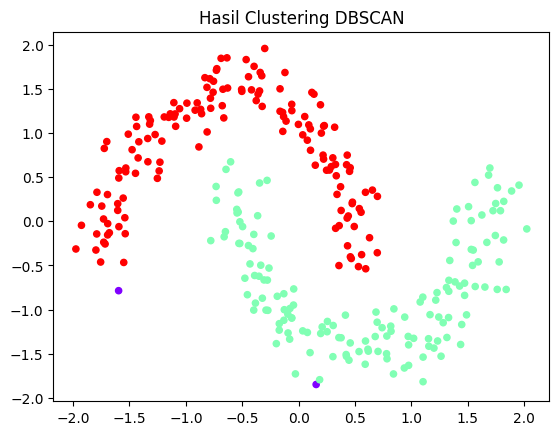

In [49]:
plt.scatter(X[:,0], X[:,1], c=labels, cmap='rainbow', s=20)
plt.title("Hasil Clustering DBSCAN")
plt.show()

**Identifikasi Core, Border, dan Noise**

In [50]:
core_indices = dbscan.core_sample_indices_
core_mask = np.zeros(len(X), dtype=bool)
core_mask[core_indices] = True

In [51]:
border_mask = (labels != -1) & (~core_mask)

In [52]:
noise = X[labels == -1]

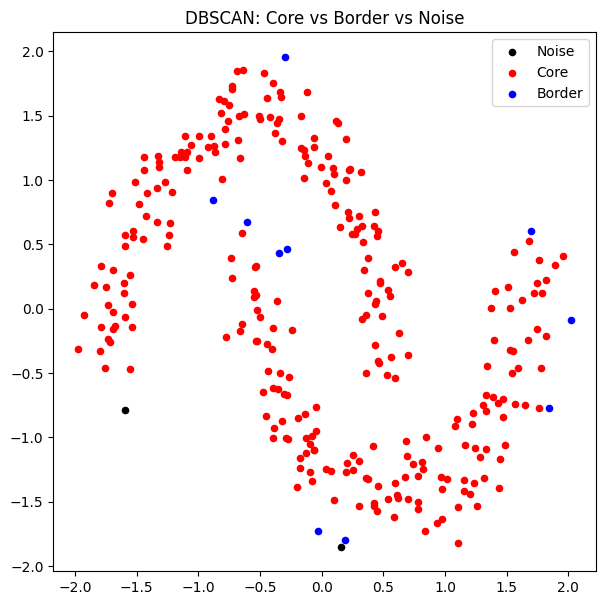

In [53]:
plt.figure(figsize=(7,7))

plt.scatter(X[labels == -1, 0], X[labels == -1, 1],
            c='black', s=20, label='Noise')

plt.scatter(X[core_mask, 0], X[core_mask, 1],
            c='red', s=20, label='Core')

plt.scatter(X[border_mask, 0], X[border_mask, 1],
            c='blue', s=20, label='Border')

plt.legend()
plt.title("DBSCAN: Core vs Border vs Noise")
plt.show()

**BAGIAN 2: Studi Kasus Mall Customers**

In [54]:
import pandas as pd
import seaborn as sns
from itertools import product
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('Mall_Customers.csv')
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

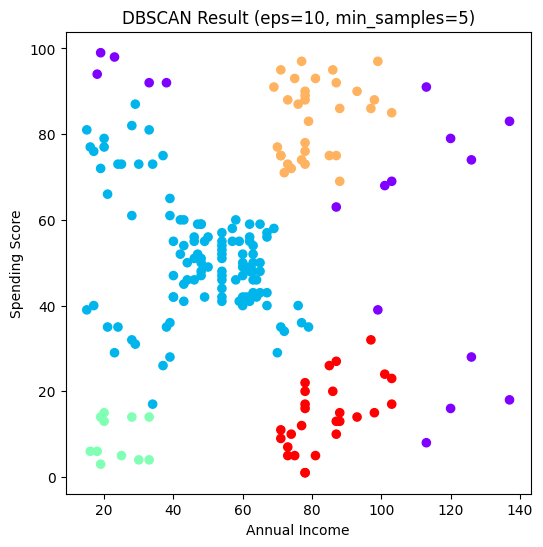

In [55]:
eps = 10
min_samples = 5

db = DBSCAN(eps=eps, min_samples=min_samples)
labels = db.fit_predict(X)

plt.figure(figsize=(6,6))
plt.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap="rainbow", s=35)
plt.title(f"DBSCAN Result (eps={eps}, min_samples={min_samples})")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()

**Mencari Parameter Optimal**

In [56]:
eps_values = np.arange(8, 12.75, 0.25)
min_points = np.arange(3, 10)
DBSCAN_params = list(product(eps_values, min_points))

**Looping Perhitungan**

In [57]:
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    try:
        db_iter = DBSCAN(eps=p[0], min_samples=p[1]).fit(X)
        labels_iter = db_iter.labels_

        unique_labels = set(labels_iter)
        n_clusters = len(unique_labels) - (1 if -1 in labels_iter else 0)
        no_of_clusters.append(n_clusters)

        if n_clusters > 0 and len(unique_labels) > 1:
            score = silhouette_score(X, labels_iter)
            sil_score.append(score)
        else:
            sil_score.append(-1)
    except:
        no_of_clusters.append(0)
        sil_score.append(-1)

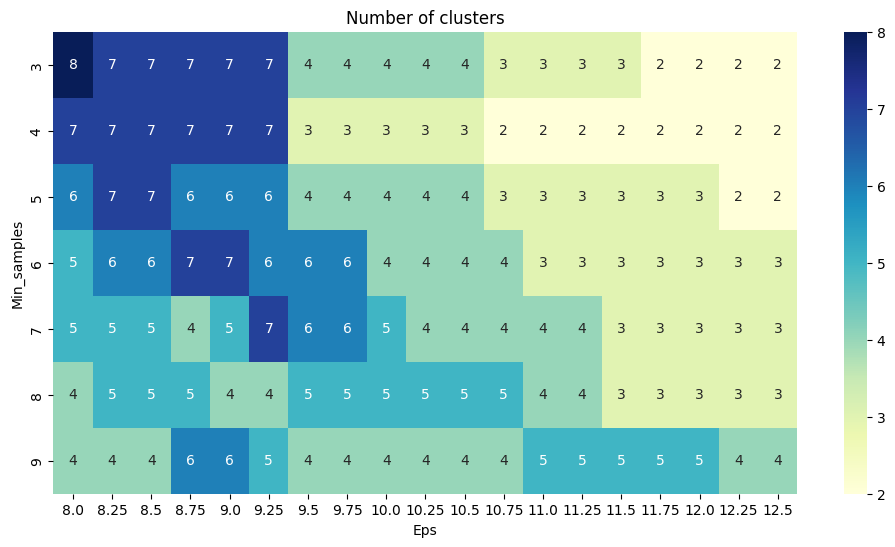

In [58]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns=['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters
pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

plt.figure(figsize=(12,6))
sns.heatmap(pivot_1, annot=True, cmap="YlGnBu")
plt.title('Number of clusters')
plt.show()

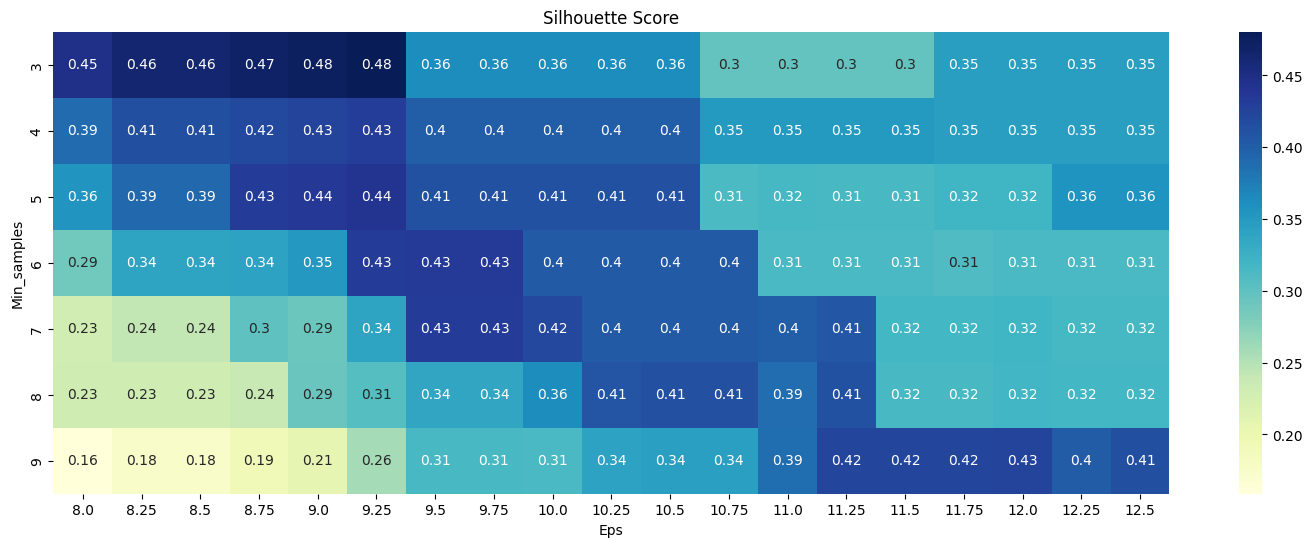

In [59]:
tmp['Sil_score'] = sil_score
pivot_2 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

plt.figure(figsize=(18,6))
sns.heatmap(pivot_2, annot=True, cmap="YlGnBu")
plt.title('Silhouette Score')
plt.show()

**Metode Knee/Elbow**

In [60]:
from sklearn.neighbors import NearestNeighbors

MinPts = 4
nbrs = NearestNeighbors(n_neighbors=MinPts).fit(X)
distances, _ = nbrs.kneighbors(X)

k_distances = np.sort(distances[:, MinPts-1])

x_axis = np.arange(len(k_distances))

p1 = np.array([x_axis[0], k_distances[0]])
p2 = np.array([x_axis[-1], k_distances[-1]])

vec_line = p2 - p1
vec_line_norm = vec_line / np.linalg.norm(vec_line)
vec_points = np.vstack((x_axis, k_distances)).T - p1
proj = np.outer(np.dot(vec_points, vec_line_norm), vec_line_norm)
dist_to_line = np.linalg.norm(vec_points - proj, axis=1)

knee_index = np.argmax(dist_to_line)
eps_opt = k_distances[knee_index]

In [61]:
print(f"Index knee: {knee_index}")
print(f"Epsilon optimal: {eps_opt:.4f}")

Index knee: 162
Epsilon optimal: 8.0623


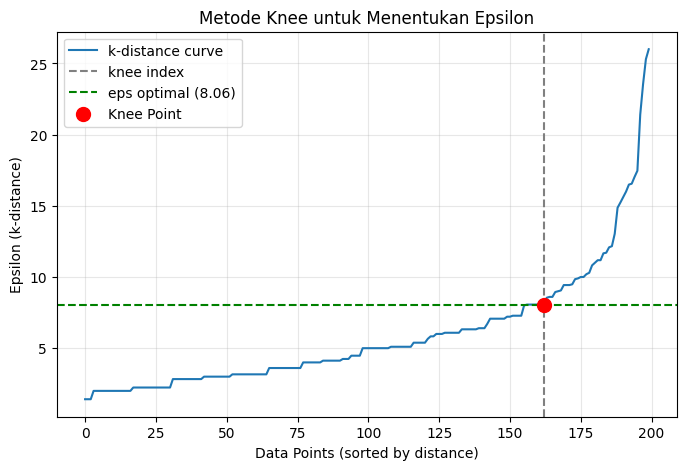

In [62]:
plt.figure(figsize=(8,5))
plt.plot(x_axis, k_distances, label="k-distance curve")
plt.axvline(knee_index, linestyle="--", color='gray', label="knee index")
plt.axhline(eps_opt, linestyle="--", color='green', label=f"eps optimal ({eps_opt:.2f})")
plt.scatter([knee_index], [eps_opt], c='red', s=100, zorder=5, label="Knee Point")

plt.title("Metode Knee untuk Menentukan Epsilon")
plt.xlabel("Data Points (sorted by distance)")
plt.ylabel("Epsilon (k-distance)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()